In [1]:
import seaborn as sns
sns.set_theme()
import pandas as pd
from pysal.lib import weights
from libpysal.io import open as psopen
import numpy as np
import matplotlib.pyplot as plt
from splot.libpysal import plot_spatial_weights
import datetime as dt # not currently used
#from geopy.distance import geodesic might be used at some point
#import peartree as pt # used to construct network
import osmnx as ox # visualisation library for networks
%matplotlib inline
import pickle
import geopandas as gp
from geopy.distance import geodesic

<string>:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).


In [2]:
municipality_codes = {
    "0101": "København",
    "0147": "Frederiksberg",
    "0151": "Ballerup",
    "0153": "Brøndby",
    "0155": "Dragør",
    "0157": "Gentofte",
    "0159": "Gladsaxe",
    "0161": "Glostrup",
    "0163": "Herlev",
    "0165": "Albertslund",
    "0167": "Hvidovre",
    "0169": "Høje-Taastrup",
    "0173": "Lyngby-Taarbæk",
    "0175": "Rødovre",
    "0183": "Ishøj",
    "0185": "Tårnby",
    "0187": "Vallensbæk",
    "0190": "Furesø",
    "0201": "Allerød",
    "0210": "Fredensborg",
    "0217": "Helsingør",
    "0219": "Hillerød",
    "0223": "Hørsholm",
    "0230": "Rudersdal",
    "0240": "Egedal",
    "0250": "Frederikssund",
    "0253": "Greve",
    "0259": "Køge",
    "0260": "Halsnæs",
    "0265": "Roskilde",
    "0269": "Solrød",
    "0270": "Gribskov",
    "0306": "Odsherred",
    "0316": "Holbæk",
    "0320": "Faxe",
    "0326": "Kalundborg",
    "0329": "Ringsted",
    "0330": "Slagelse",
    "0336": "Stevns",
    "0340": "Sorø",
    "0350": "Lejre",
    "0360": "Lolland",
    "0370": "Næstved",
    "0376": "Guldborgsund",
    "0390": "Vordingborg",
    "0400": "Bornholm",
    "0410": "Middelfart",
    "0411": "Christiansø",
    "0420": "Assens",
    "0430": "Faaborg-Midtfyn",
    "0440": "Kerteminde",
    "0450": "Nyborg",
    "0461": "Odense",
    "0479": "Svendborg",
    "0480": "Nordfyns",
    "0482": "Langeland",
    "0492": "Ærø",
    "0510": "Haderslev",
    "0530": "Billund",
    "0540": "Sønderborg",
    "0550": "Tønder",
    "0561": "Esbjerg",
    "0563": "Fanø",
    "0573": "Varde",
    "0575": "Vejen",
    "0580": "Aabenraa",
    "0607": "Fredericia",
    "0615": "Horsens",
    "0621": "Kolding",
    "0630": "Vejle",
    "0657": "Herning",
    "0661": "Holstebro",
    "0665": "Lemvig",
    "0671": "Struer",
    "0706": "Syddjurs",
    "0707": "Norddjurs",
    "0710": "Favrskov",
    "0727": "Odder",
    "0730": "Randers",
    "0740": "Silkeborg",
    "0741": "Samsø",
    "0746": "Skanderborg",
    "0751": "Aarhus",
    "0756": "Ikast-Brande",
    "0760": "Ringkøbing-Skjern",
    "0766": "Hedensted",
    "0773": "Morsø",
    "0779": "Skive",
    "0787": "Thisted",
    "0791": "Viborg",
    "0810": "Brønderslev",
    "0813": "Frederikshavn",
    "0820": "Vesthimmerlands",
    "0825": "Læsø",
    "0840": "Rebild",
    "0846": "Mariagerfjord",
    "0849": "Jammerbugt",
    "0851": "Aalborg",
    "0860": "Hjørring"
}

In [36]:
af_shapefile = "data/DAGI/afstemningsomraade/afstemningsomraade.shp"
afstemningsomraade_df = gp.read_file(af_shapefile)
# Index table on the id
#db.rename({"id.lokalId":"area_id"},axis=1, inplace=True) # First, let's rename the column to something a bit easier to write
#db = db.set_index("area_id",drop=False) # we use the id columns as index for easy access to our spatial weights 

# NOTE if the data set is too large for your laptop, you can uncomment the next code line and work on a smaller subset
# This will break the section on islands using block weights, but everything else should work
# Select subset for Roskilde
# db = db.loc[db.kommunekode.isin(['0265','0169','0253','0183'])]

# Display summary
afstemningsomraade_df.head()

,objectid,id_lokalid,id_namespa,status,geometrist,virkningfr,virkningti,virkningsa,forretning,registreri,...,afstemning,afstemni00,afstemni01,kommunekod,kommunelok,opstilling,opstilli00,udtraeksda,gmlid,geometry
0,1285591,711178,http://data.gov.dk/dagi,vedtaget,endelig,20181127000000,None,Andet,systemetablering,20181127115950.448,...,03,"Alt-i-et-Huset, Aktivitetstorvet",0A3F5092-3B74-32B8-E044-0003BA298018,0665,389183,73,403588,2020-04-20,dagi.711178,MULTIPOLYGON Z (((456759.440 6269326.060 0.000...
1,1295999,706714,http://data.gov.dk/dagi,vedtaget,endelig,20190429000000,None,Andet,systemetablering,20190429145414.863,...,01,Vestre Skole - Multisalen,0A3F5088-AE52-32B8-E044-0003BA298018,0410,389156,45,403613,2020-04-20,dagi.706714,MULTIPOLYGON Z (((545858.940 6150025.530 0.000...
2,1285601,701882,http://data.gov.dk/dagi,vedtaget,endelig,20181127000000,None,Andet,systemetablering,20181127115950.448,...,08,Harboøre Centeret,0A3F5092-AF81-32B8-E044-0003BA298018,0665,389183,73,403588,2020-04-20,dagi.701882,MULTIPOLYGON Z (((452428.420 6275466.130 0.000...
3,1285615,712242,http://data.gov.dk/dagi,vedtaget,endelig,20181127000000,None,Andet,systemetablering,20181127115950.448,...,05,"Bøvling Friskole, Gymnastiksalen",0A3F5092-346A-32B8-E044-0003BA298018,0665,389183,73,403588,2020-04-20,dagi.712242,MULTIPOLYGON Z (((449043.530 6250292.870 0.000...
4,1285617,711198,http://data.gov.dk/dagi,vedtaget,endelig,20181127000000,None,Andet,systemetablering,20181127115950.448,...,06,"Tangsø Centret, Mødelokalet",0A3F5092-42F6-32B8-E044-0003BA298018,0665,389183,73,403588,2020-04-20,dagi.711198,"POLYGON Z ((466126.570 6254639.180 0.000, 4661..."


In [37]:
afstemningsomraade_df.columns

Index(['objectid', 'id_lokalid', 'id_namespa', 'status', 'geometrist',
       'virkningfr', 'virkningti', 'virkningsa', 'forretning', 'registreri',
       'registre00', 'registre01', 'forretni00', 'forretni01', 'dagiid',
       'navn', 'redigering', 'dataspecif', 'landekode', 'skala', 'afstemning',
       'afstemni00', 'afstemni01', 'kommunekod', 'kommunelok', 'opstilling',
       'opstilli00', 'udtraeksda', 'gmlid', 'geometry'],
      dtype='object')

<Axes: >

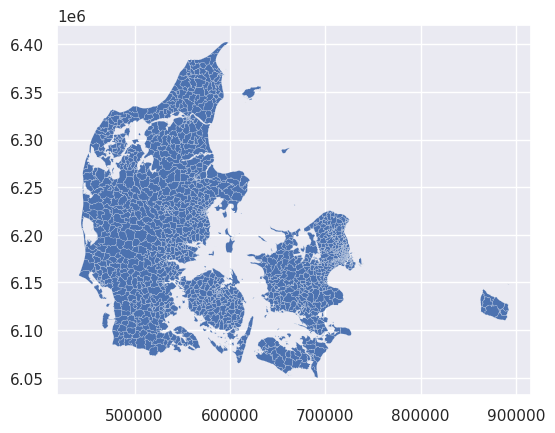

In [38]:
afstemningsomraade_df.plot(linewidth=0.1)

In [3]:
shapefile = "data/DAGI/kommuneinddeling/kommuneinddeling.shp"
kommuner_df = gp.read_file(shapefile)
# Index table on the id
#db.rename({"id.lokalId":"area_id"},axis=1, inplace=True) # First, let's rename the column to something a bit easier to write
#db = db.set_index("area_id",drop=False) # we use the id columns as index for easy access to our spatial weights 

# NOTE if the data set is too large for your laptop, you can uncomment the next code line and work on a smaller subset
# This will break the section on islands using block weights, but everything else should work
# Select subset for Roskilde
# db = db.loc[db.kommunekode.isin(['0265','0169','0253','0183'])]

# Display summary
kommuner_df.head()

,objectid,id_lokalid,id_namespa,status,geometrist,virkningfr,virkningti,virkningsa,forretning,registreri,...,landekode,skala,kommunekod,lau1vaerdi,udenforkom,regionskod,regionslok,udtraeksda,gmlid,geometry
0,1284412,389183,http://data.gov.dk/dagi,vedtaget,endelig,20181102000000,None,Geodatastyrelsen,matrikulærAjourføring,20181102081410.437,...,DK,1:10.000,0665,665,f,1082,389101,2020-04-20,dagi.389183,MULTIPOLYGON Z (((446115.180 6250956.630 0.000...
1,1284617,389199,http://data.gov.dk/dagi,vedtaget,endelig,20181107000000,None,Geodatastyrelsen,matrikulærAjourføring,20181107121715.346,...,DK,1:10.000,0810,810,f,1081,389098,2020-04-20,dagi.389199,"POLYGON Z ((556389.890 6342937.290 0.000, 5563..."
2,1284619,389206,http://data.gov.dk/dagi,vedtaget,endelig,20181107000000,None,Geodatastyrelsen,matrikulærAjourføring,20181107121715.346,...,DK,1:10.000,0851,851,f,1081,389098,2020-04-20,dagi.389206,MULTIPOLYGON Z (((557400.690 6323373.320 0.000...
3,1284689,389175,http://data.gov.dk/dagi,vedtaget,endelig,20181108000000,None,Geodatastyrelsen,FOTAjourføring,20181108130916.952,...,DK,1:10.000,0607,607,f,1083,389102,2020-04-20,dagi.389175,MULTIPOLYGON Z (((537517.320 6152061.430 0.000...
4,1287002,389140,http://data.gov.dk/dagi,vedtaget,endelig,20190101000000,None,Geodatastyrelsen,matrikulærAjourføring,20190107122901.497,...,DK,1:10.000,0316,316,f,1085,389100,2020-04-20,dagi.389140,MULTIPOLYGON Z (((674151.550 6184820.700 0.000...


<Axes: >

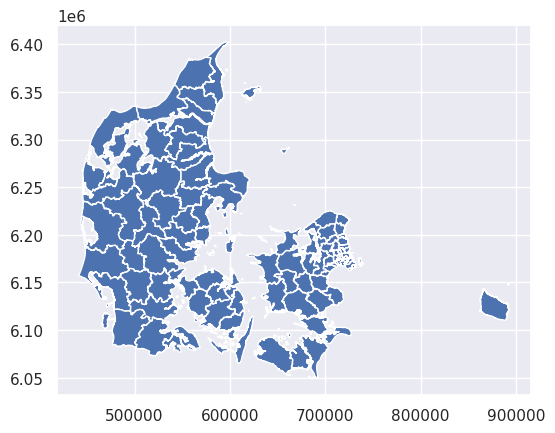

In [4]:
kommuner_df.plot()

In [5]:
w_queen = weights.Queen.from_dataframe(kommuner_df, idVariable="kommunekod")
w_queen

/opt/conda/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
 There are 8 islands with ids: 0400, 0411, 0482, 0492, 0563, 0741, 0773, 0825.
  warnings.warn(message)


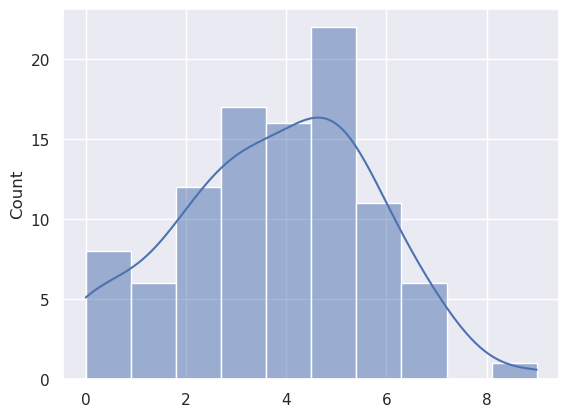

In [6]:
queen_card = pd.Series(w_queen.cardinalities)
sns.histplot(queen_card, bins=10, kde=True); # stat="density"

Distribution of number of neighbours of municipalities is quite flat with a spike around 5 neighbours

In [7]:
print("Average number of neighbors:",w_queen.mean_neighbors)
print("Min number of neighbors:",w_queen.min_neighbors,"(there's islands)")
print("Max number of neighbors:",w_queen.max_neighbors)
print("Island municipalities:",[municipality_codes[island] for island in w_queen.islands])

Average number of neighbors: 3.757575757575758
Min number of neighbors: 0 (there's islands)
Max number of neighbors: 9
Island municipalities: ['Bornholm', 'Christiansø', 'Langeland', 'Ærø', 'Fanø', 'Samsø', 'Morsø', 'Læsø']


In [8]:
knn5 = weights.KNN.from_dataframe(kommuner_df, k=5)
knn5

In [9]:
# Extract centroids
cents = kommuner_df.centroid
# Extract coordinates into an array
pts = pd.DataFrame(
    {"X": cents.x, "Y": cents.y}
).values
# Compute KNN weights
knn5_from_pts = weights.KNN.from_array(pts, k=5)
knn5_from_pts

In [22]:
w_dist10kmB = weights.DistanceBand.from_dataframe(kommuner_df, 40000)

/opt/conda/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 20.
  warnings.warn(message)


In [26]:
w_dist10kmC = weights.DistanceBand.from_dataframe(kommuner_df, 30000, binary=False)

/opt/conda/lib/python3.10/site-packages/scipy/sparse/_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
/opt/conda/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 13 disconnected components.
 There are 9 islands with ids: 10, 20, 34, 60, 69, 74, 80, 85, 95.
  warnings.warn(message)


In [20]:
min_thr = weights.min_threshold_distance(pts)
min_thr


40215.34997293318

In [21]:
w_min_dist = weights.DistanceBand.from_dataframe(kommuner_df, round(min_thr), binary=False)

/opt/conda/lib/python3.10/site-packages/scipy/sparse/_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
/opt/conda/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 20.
  warnings.warn(message)


In [27]:
kommuner_df.head()

,objectid,id_lokalid,id_namespa,status,geometrist,virkningfr,virkningti,virkningsa,forretning,registreri,...,landekode,skala,kommunekod,lau1vaerdi,udenforkom,regionskod,regionslok,udtraeksda,gmlid,geometry
0,1284412,389183,http://data.gov.dk/dagi,vedtaget,endelig,20181102000000,None,Geodatastyrelsen,matrikulærAjourføring,20181102081410.437,...,DK,1:10.000,0665,665,f,1082,389101,2020-04-20,dagi.389183,MULTIPOLYGON Z (((446115.180 6250956.630 0.000...
1,1284617,389199,http://data.gov.dk/dagi,vedtaget,endelig,20181107000000,None,Geodatastyrelsen,matrikulærAjourføring,20181107121715.346,...,DK,1:10.000,0810,810,f,1081,389098,2020-04-20,dagi.389199,"POLYGON Z ((556389.890 6342937.290 0.000, 5563..."
2,1284619,389206,http://data.gov.dk/dagi,vedtaget,endelig,20181107000000,None,Geodatastyrelsen,matrikulærAjourføring,20181107121715.346,...,DK,1:10.000,0851,851,f,1081,389098,2020-04-20,dagi.389206,MULTIPOLYGON Z (((557400.690 6323373.320 0.000...
3,1284689,389175,http://data.gov.dk/dagi,vedtaget,endelig,20181108000000,None,Geodatastyrelsen,FOTAjourføring,20181108130916.952,...,DK,1:10.000,0607,607,f,1083,389102,2020-04-20,dagi.389175,MULTIPOLYGON Z (((537517.320 6152061.430 0.000...
4,1287002,389140,http://data.gov.dk/dagi,vedtaget,endelig,20190101000000,None,Geodatastyrelsen,matrikulærAjourføring,20190107122901.497,...,DK,1:10.000,0316,316,f,1085,389100,2020-04-20,dagi.389140,MULTIPOLYGON Z (((674151.550 6184820.700 0.000...


In [28]:
w_block = weights.block_weights(kommuner_df['kommunekod'])

/opt/conda/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 99 disconnected components.
 There are 99 islands with ids: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98.
  warnings.warn(message)


In [65]:
af_shapefile = "data/DAGI/afstemningsomraade/afstemningsomraade.shp"
afstemningsomraade_df = gp.read_file(af_shapefile)
afstemningsomraade_df = afstemningsomraade_df.set_index("objectid",drop=False)
# Index table on the id
#db.rename({"id.lokalId":"area_id"},axis=1, inplace=True) # First, let's rename the column to something a bit easier to write
#db = db.set_index("area_id",drop=False) # we use the id columns as index for easy access to our spatial weights 

# NOTE if the data set is too large for your laptop, you can uncomment the next code line and work on a smaller subset
# This will break the section on islands using block weights, but everything else should work
# Select subset for Roskilde
# db = db.loc[db.kommunekode.isin(['0265','0169','0253','0183'])]

# Display summary
afstemningsomraade_df.head()

,objectid,id_lokalid,id_namespa,status,geometrist,virkningfr,virkningti,virkningsa,forretning,registreri,...,afstemning,afstemni00,afstemni01,kommunekod,kommunelok,opstilling,opstilli00,udtraeksda,gmlid,geometry
objectid,,,,,,,,,,,,,,,,,,,,,
1285591,1285591,711178,http://data.gov.dk/dagi,vedtaget,endelig,20181127000000,None,Andet,systemetablering,20181127115950.448,...,03,"Alt-i-et-Huset, Aktivitetstorvet",0A3F5092-3B74-32B8-E044-0003BA298018,0665,389183,73,403588,2020-04-20,dagi.711178,MULTIPOLYGON Z (((456759.440 6269326.060 0.000...
1295999,1295999,706714,http://data.gov.dk/dagi,vedtaget,endelig,20190429000000,None,Andet,systemetablering,20190429145414.863,...,01,Vestre Skole - Multisalen,0A3F5088-AE52-32B8-E044-0003BA298018,0410,389156,45,403613,2020-04-20,dagi.706714,MULTIPOLYGON Z (((545858.940 6150025.530 0.000...
1285601,1285601,701882,http://data.gov.dk/dagi,vedtaget,endelig,20181127000000,None,Andet,systemetablering,20181127115950.448,...,08,Harboøre Centeret,0A3F5092-AF81-32B8-E044-0003BA298018,0665,389183,73,403588,2020-04-20,dagi.701882,MULTIPOLYGON Z (((452428.420 6275466.130 0.000...
1285615,1285615,712242,http://data.gov.dk/dagi,vedtaget,endelig,20181127000000,None,Andet,systemetablering,20181127115950.448,...,05,"Bøvling Friskole, Gymnastiksalen",0A3F5092-346A-32B8-E044-0003BA298018,0665,389183,73,403588,2020-04-20,dagi.712242,MULTIPOLYGON Z (((449043.530 6250292.870 0.000...
1285617,1285617,711198,http://data.gov.dk/dagi,vedtaget,endelig,20181127000000,None,Andet,systemetablering,20181127115950.448,...,06,"Tangsø Centret, Mødelokalet",0A3F5092-42F6-32B8-E044-0003BA298018,0665,389183,73,403588,2020-04-20,dagi.711198,"POLYGON Z ((466126.570 6254639.180 0.000, 4661..."


In [43]:
afstemningsomraade_df.columns

Index(['objectid', 'id_lokalid', 'id_namespa', 'status', 'geometrist',
       'virkningfr', 'virkningti', 'virkningsa', 'forretning', 'registreri',
       'registre00', 'registre01', 'forretni00', 'forretni01', 'dagiid',
       'navn', 'redigering', 'dataspecif', 'landekode', 'skala', 'afstemning',
       'afstemni00', 'afstemni01', 'kommunekod', 'kommunelok', 'opstilling',
       'opstilli00', 'udtraeksda', 'gmlid', 'geometry'],
      dtype='object')

<Axes: >

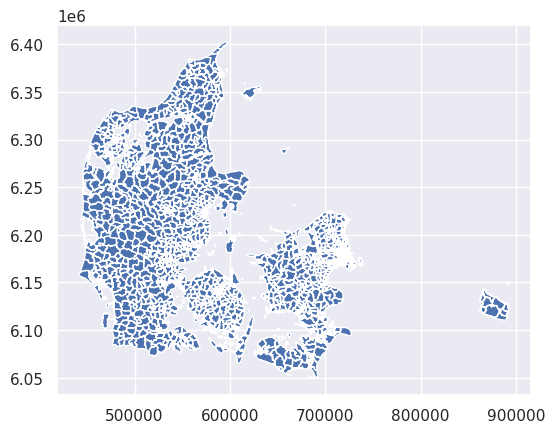

In [40]:
afstemningsomraade_df.plot()

In [44]:
w_queen = weights.Queen.from_dataframe(afstemningsomraade_df, idVariable="objectid")
w_queen

/opt/conda/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 34 disconnected components.
 There are 21 islands with ids: 1275732, 1276479, 1276595, 1277711, 1277942, 1280527, 1284873, 1289257, 1294128, 1294150, 1294160, 1295326, 1295422, 1295804, 1295808, 1298728, 1299718, 1299754, 1300952, 1304283, 1306186.
  warnings.warn(message)


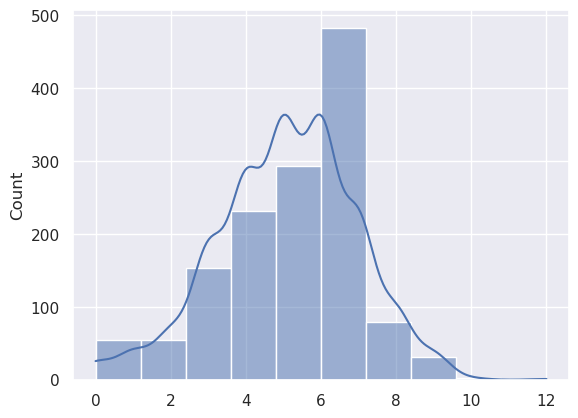

In [45]:
queen_card = pd.Series(w_queen.cardinalities)
sns.histplot(queen_card, bins=10, kde=True); # stat="density"

In [46]:
print("Average number of neighbors:",w_queen.mean_neighbors)
print("Min number of neighbors:",w_queen.min_neighbors,"(there's islands)")
print("Max number of neighbors:",w_queen.max_neighbors)
#print("Island municipalities:",[municipality_codes[island] for island in w_queen.islands])

Average number of neighbors: 5.079479768786127
Min number of neighbors: 0 (there's islands)
Max number of neighbors: 12


In [47]:
knn5 = weights.KNN.from_dataframe(afstemningsomraade_df, k=5)
knn5

/opt/conda/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [48]:
# Extract centroids
cents = afstemningsomraade_df.centroid
# Extract coordinates into an array
pts = pd.DataFrame(
    {"X": cents.x, "Y": cents.y}
).values
# Compute KNN weights
knn5_from_pts = weights.KNN.from_array(pts, k=5)
knn5_from_pts

/opt/conda/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [49]:
w_dist10kmB = weights.DistanceBand.from_dataframe(afstemningsomraade_df, 10000)

/opt/conda/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 23 disconnected components.
 There are 16 islands with ids: 58, 129, 211, 228, 264, 294, 297, 314, 404, 466, 599, 632, 672, 697, 701, 1123.
  warnings.warn(message)


In [52]:
w_dist10kmC = weights.DistanceBand.from_dataframe(afstemningsomraade_df, 10000, binary=False)

/opt/conda/lib/python3.10/site-packages/scipy/sparse/_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
/opt/conda/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 23 disconnected components.
 There are 16 islands with ids: 58, 129, 211, 228, 264, 294, 297, 314, 404, 466, 599, 632, 672, 697, 701, 1123.
  warnings.warn(message)


In [51]:
min_thr = weights.min_threshold_distance(pts)
min_thr

53310.82392119043

In [53]:
w_min_dist = weights.DistanceBand.from_dataframe(afstemningsomraade_df, round(min_thr), binary=False)

/opt/conda/lib/python3.10/site-packages/scipy/sparse/_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
/opt/conda/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [55]:
w_block = weights.block_weights(afstemningsomraade_df['kommunekod'])

/opt/conda/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 99 disconnected components.
 There are 2 islands with ids: 211, 697.
  warnings.warn(message)


In [56]:
w_block

In [57]:
w_block.islands

[211, 697]

In [59]:
w_block.remap_ids(afstemningsomraade_df.objectid)

In [62]:
afstemningsomraade_df.columns

Index(['objectid', 'id_lokalid', 'id_namespa', 'status', 'geometrist',
       'virkningfr', 'virkningti', 'virkningsa', 'forretning', 'registreri',
       'registre00', 'registre01', 'forretni00', 'forretni01', 'dagiid',
       'navn', 'redigering', 'dataspecif', 'landekode', 'skala', 'afstemning',
       'afstemni00', 'afstemni01', 'kommunekod', 'kommunelok', 'opstilling',
       'opstilli00', 'udtraeksda', 'gmlid', 'geometry'],
      dtype='object')

In [66]:
afstemningsomraade_df.loc[w_block.islands,['navn','afstemni00']]

,navn,afstemni00
objectid,,
1280527,Læsø,Læsø Hallen
1276595,Christiansø,Gæstgiveriet


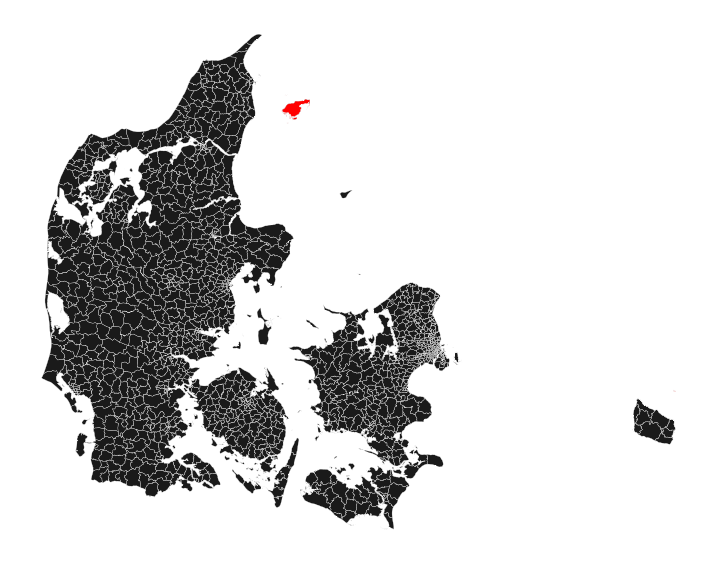

In [67]:
ax = afstemningsomraade_df.plot(color='k', linewidth=0.2, figsize=(9, 9))
afstemningsomraade_df.loc[w_block.islands, :].plot(color='red', linewidth=0.2, ax=ax)
ax.set_axis_off()

In [68]:
# Row-standardize the queen matrix
w_queen.transform = 'R'
# Compute spatial lag of `area`
w_queen_score = weights.lag_spatial(w_queen, db["area"])
# Print the first five elements
w_queen_score[:5]

('WARNING: ', '1289257', ' is an island (no neighbors)')
('WARNING: ', '1280527', ' is an island (no neighbors)')
('WARNING: ', '1284873', ' is an island (no neighbors)')
('WARNING: ', '1277942', ' is an island (no neighbors)')
('WARNING: ', '1276479', ' is an island (no neighbors)')
('WARNING: ', '1275732', ' is an island (no neighbors)')
('WARNING: ', '1304283', ' is an island (no neighbors)')
('WARNING: ', '1295326', ' is an island (no neighbors)')
('WARNING: ', '1276595', ' is an island (no neighbors)')
('WARNING: ', '1277711', ' is an island (no neighbors)')
('WARNING: ', '1294128', ' is an island (no neighbors)')
('WARNING: ', '1294150', ' is an island (no neighbors)')
('WARNING: ', '1294160', ' is an island (no neighbors)')
('WARNING: ', '1295422', ' is an island (no neighbors)')
('WARNING: ', '1295804', ' is an island (no neighbors)')
('WARNING: ', '1295808', ' is an island (no neighbors)')
('WARNING: ', '1298728', ' is an island (no neighbors)')
('WARNING: ', '1306186', ' is a

NameError: name 'db' is not defined